<a href="https://colab.research.google.com/github/kmouleejunhyuk/windturbine/blob/main/windturbine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 풍력발전기 상태이상 판별 과제

In [1]:
###
#python, pytorch
#data not encluded due to copyrights issue

In [59]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import sys
import time
import random

In [3]:
#구글 드라이브 마운트 & 경로설정
from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/windturbine'

Mounted at /gdrive


In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)

using device:  cuda


In [97]:
#seed for reproducability
random_seed=49   #44159
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#### Data loading and EDA

In [98]:
#data import
train_raw=pd.read_csv(PATH+'/training_data_set.csv')
test_raw=pd.read_csv(PATH+'/validation_data_set.csv')

In [99]:
#EDA helper function
def EDA(df: pd.DataFrame):
    print(df.head(), '\n')
    print(df.dtypes, '\n')

    for _ in df.columns:
        if df[_].isna().sum() != 0 or df[_].dtypes != 'float64':
            #static information
            print('column '+ _ + ' static info')
            print('max:', '\t\t', df[_].max())
            print('min:', '\t\t', df[_].min())
            print('avg:', '\t\t', df[_].mean())
            print('count of na: ', '\t\t', df[_].isna().sum())
            print('unique values: ', '\t\t', df[_].nunique(dropna=False))

            #plot boxplot by column
            source=df[_].copy()
            plt.rcParams['figure.figsize']=[10, 6]
            plt.title(_)
            plt.boxplot(source, notch=1, sym='rs', vert=0)
            plt.show()
            plt.close()
            print('\n')

        #else: print('no na and float value in column {}. max: {}, min: {}, avg: {} \n'.format(_, df[_].max(), df[_].min(), df[_].mean()))

          1         2    3    4         5  ...  682  683  684  685  686
0  0.621211  0.771822  0.5  0.5  0.618948  ...    0    0    0    0    1
1  0.624648  0.319315  0.5  0.5  0.625634  ...    0    0    0    0    1
2  0.625174  0.244754  0.5  0.5  0.626474  ...    0    0    0    0    1
3  0.628112  0.266645  0.5  0.5  0.627791  ...    0    0    0    0    1
4  0.629918  0.204191  0.5  0.5  0.629838  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


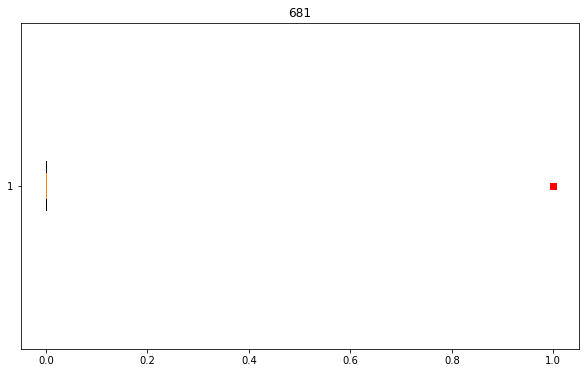



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


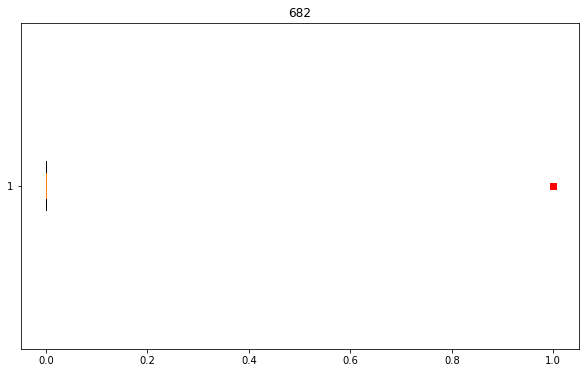



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.14625
count of na:  		 0
unique values:  		 2


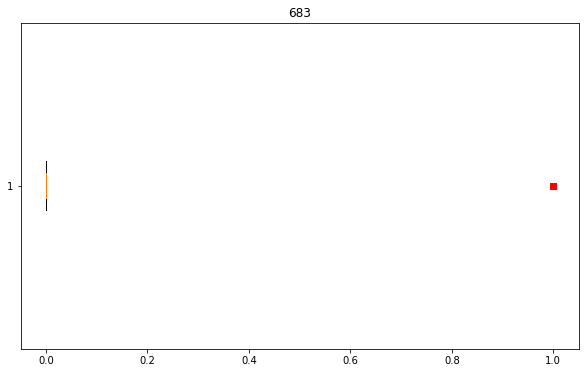



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


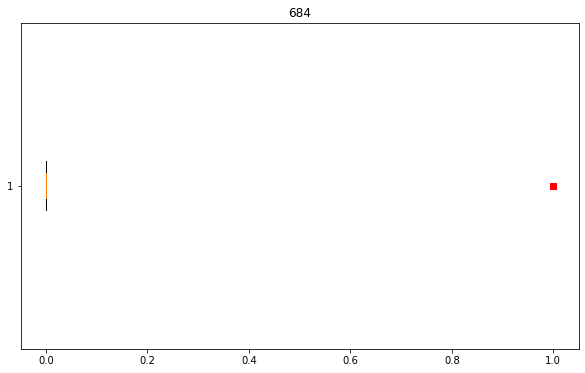



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.16375
count of na:  		 0
unique values:  		 2


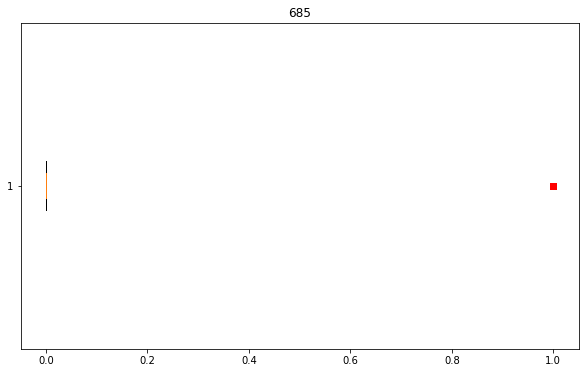



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


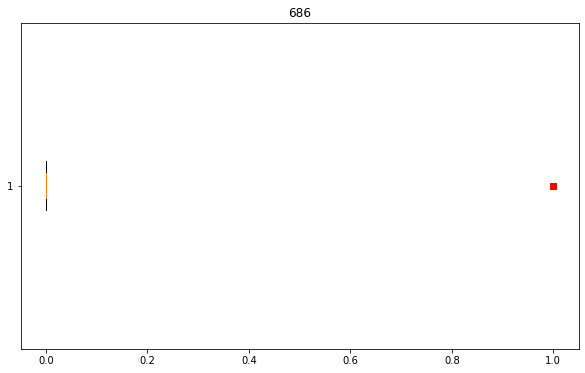

In [100]:
EDA(train_raw)

          1         2    3    4         5  ...  682  683  684  685  686
0  1.019280  1.240127  0.5  0.5  1.018462  ...    0    0    0    0    1
1  1.019262  1.248247  0.5  0.5  1.018890  ...    0    0    0    0    1
2  1.023792  1.286444  0.5  0.5  1.024392  ...    0    0    0    0    1
3  1.023431  1.364974  0.5  0.5  1.023545  ...    0    0    0    0    1
4  1.018795  1.277456  0.5  0.5  1.021053  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


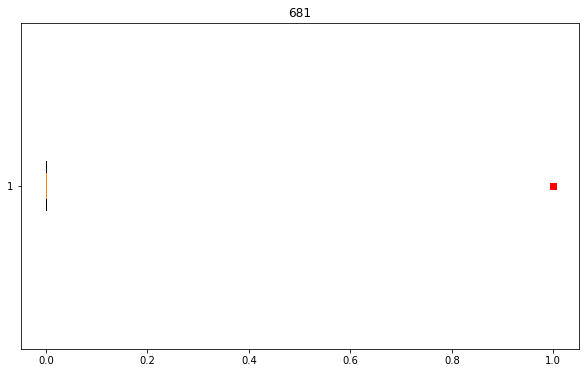



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


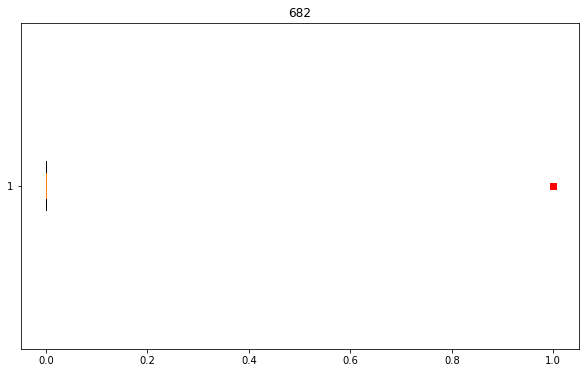



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


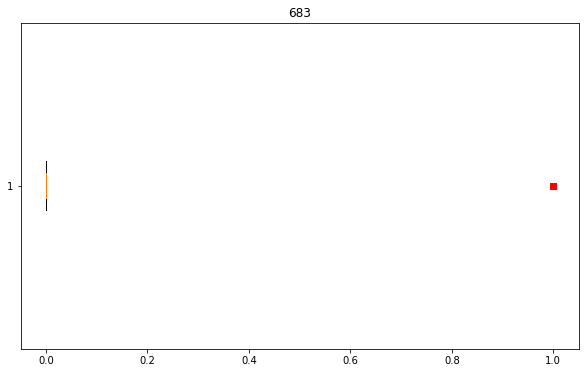



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


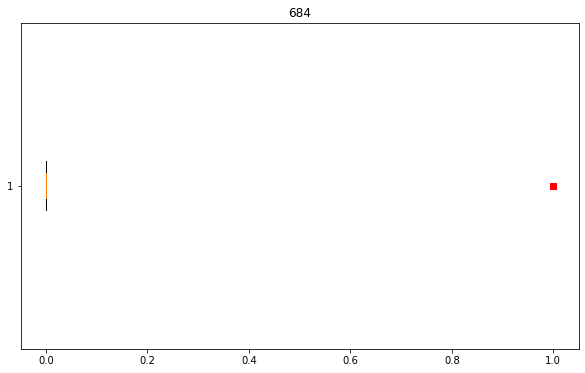



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.22
count of na:  		 0
unique values:  		 2


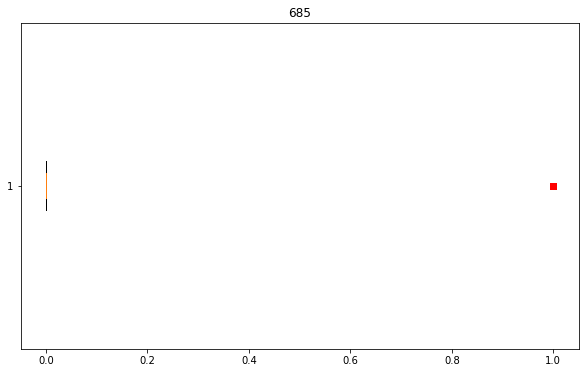



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.14
count of na:  		 0
unique values:  		 2


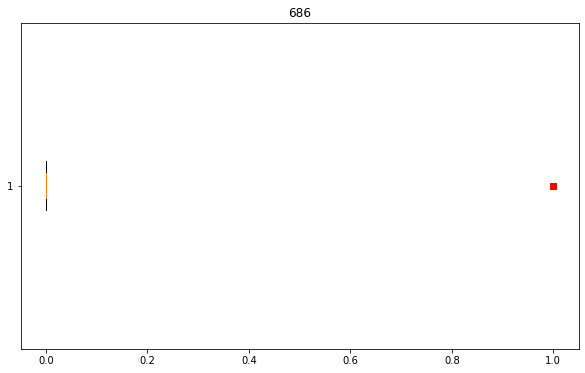

In [101]:
EDA(test_raw)

In [102]:
##column 681~686 seems to be one-hot encoded target value

#### preparing data

In [103]:
y_train=train_raw[[str(x) for x in range(681, 687)]]
x_train=train_raw[[str(x) for x in range(1, 681)]]

y_test=test_raw[[str(x) for x in range(681, 687)]]
x_test=test_raw[[str(x) for x in range(1, 681)]]

In [104]:
y_train.iloc[0]

681    0
682    0
683    0
684    0
685    0
686    1
Name: 0, dtype: int64

In [105]:
#changing one-hot encoded target value to single integer value(0~6)
y_train['target']=np.argmax(y_train.copy().values, axis=1)
y_test['target']=np.argmax(y_test.copy().values, axis=1)

y_train=y_train['target'].copy()
y_test=y_test['target'].copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
np.unique(y_test.values, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([3800, 2600, 3800, 2600, 4400, 2800]))

In [107]:
from sklearn.preprocessing import RobustScaler
trans=RobustScaler().fit(x_train.values)
x_train=pd.DataFrame(data=trans.transform(x_train.values), columns=x_train.columns)
x_test=pd.DataFrame(data=trans.transform(x_test.values), columns=x_test.columns)

In [108]:
x_train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680
0,-0.638696,-0.274198,0.000000,0.000000,-0.643450,-0.259082,0.000000,0.000000,-0.644033,-0.251133,0.000000,0.000000,-0.640694,-0.255761,0.000000,0.000000,-0.640462,-0.254408,0.000000,0.000000,-0.639125,-0.249460,0.000000,0.000000,-0.638966,-0.243610,0.000000,0.000000,-0.639666,-0.238538,0.000000,0.000000,-0.637522,-0.238779,0.000000,0.000000,-0.637047,-0.235668,0.000000,0.000000,...,-0.613856,-0.007356,0.000000,0.000000,-0.610728,-0.017820,0.000000,0.000000,-0.606801,-0.038305,0.000000,0.000000,-0.610239,-0.045013,0.000000,0.000000,-0.611967,-0.045306,0.000000,0.000000,-0.608776,-0.059574,0.000000,0.000000,-0.609188,-0.072074,0.000000,0.000000,-0.606435,-0.088470,0.000000,0.000000,-0.607640,-0.097835,0.000000,0.000000,-0.605381,-0.111868,0.000000,0.000000
1,-0.630694,-1.330620,0.000000,0.000000,-0.627893,-1.323053,0.000000,0.000000,-0.630415,-1.311774,0.000000,0.000000,-0.625998,-1.306653,0.000000,0.000000,-0.627651,-1.296394,0.000000,0.000000,-0.627090,-1.285548,0.000000,0.000000,-0.625951,-1.278005,0.000000,0.000000,-0.628121,-1.265507,0.000000,0.000000,-0.629558,-1.251780,0.000000,0.000000,-0.629599,-1.240778,0.000000,0.000000,...,-0.614536,-1.342777,0.000000,0.000000,-0.613269,-1.342667,0.000000,0.000000,-0.612726,-1.341227,0.000000,0.000000,-0.610809,-1.341835,0.000000,0.000000,-0.611454,-1.344473,0.000000,0.000000,-0.612879,-1.343450,0.000000,0.000000,-0.610449,-1.344849,0.000000,0.000000,-0.610620,-1.346050,0.000000,0.000000,-0.610975,-1.349449,0.000000,0.000000,-0.610248,-1.355725,0.000000,0.000000
2,-0.629469,-1.504690,0.000000,0.000000,-0.625938,-1.505326,0.000000,0.000000,-0.628000,-1.499351,0.000000,0.000000,-0.628747,-1.492310,0.000000,0.000000,-0.625154,-1.490117,0.000000,0.000000,-0.623536,-1.486200,0.000000,0.000000,-0.622375,-1.480620,0.000000,0.000000,-0.619866,-1.478210,0.000000,0.000000,-0.619788,-1.471147,0.000000,0.000000,-0.621150,-1.462677,0.000000,0.000000,...,-0.606294,-1.336166,0.000000,0.000000,-0.602693,-1.343991,0.000000,0.000000,-0.604796,-1.346042,0.000000,0.000000,-0.608720,-1.343170,0.000000,0.000000,-0.604080,-1.353881,0.000000,0.000000,-0.600876,-1.361669,0.000000,0.000000,-0.600432,-1.361198,0.000000,0.000000,-0.600633,-1.361526,0.000000,0.000000,-0.603219,-1.358560,0.000000,0.000000,-0.602708,-1.360459,0.000000,0.000000
3,-0.622629,-1.453583,0.000000,0.000000,-0.622874,-1.455835,0.000000,0.000000,-0.621065,-1.459464,0.000000,0.000000,-0.619437,-1.464296,0.000000,0.000000,-0.619067,-1.469839,0.000000,0.000000,-0.623848,-1.466944,0.000000,0.000000,-0.621919,-1.466065,0.000000,0.000000,-0.624063,-1.464280,0.000000,0.000000,-0.621908,-1.464732,0.000000,0.000000,-0.619576,-1.467860,0.000000,0.000000,...,-0.596849,-1.811328,0.000000,0.000000,-0.598538,-1.813527,0.000000,0.000000,-0.600680,-1.817227,0.000000,0.000000,-0.597935,-1.823977,0.000000,0.000000,-0.600038,-1.827485,0.000000,0.000000,-0.600931,-1.829093,0.000000,0.000000,-0.601975,-1.831409,0.000000,0.000000,-0.602688,-1.836020,0.000000,0.000000,-0.604976,-1.838098,0.000000,0.000000,-0.606708,-1.839863,0.000000,0.000000
4,-0.618424,-1.599388,0.000000,0.000000,-0.618111,-1.607681,0.000000,0.000000,-0.617374,-1.617419,0.000000,0.000000,-0.618912,-1.623629,0.000000,0.000000,-0.620682,-1.628842,0.000000,0.000000,-0.623041,-1.634236,0.000000,0.000000,-0.622512,-1.641121,0.000000,0.000000,-0.624389,-1.646182,0.000000,0.000000,-0.625625,-1.647569,0.000000,0.000000,-0.624879,-1.655354,0.000000,0.000000,...,-0.605838,-1.887984,0.000000,0.000000,-0.606608,-1.883795,0.000000,0.000000,-0.607741,-1.883392,0.000000,0.000000,-0.607888,-1.883363,0.000000,0.000000,-0.610828,-1.883203,0.000000,0.000000,-0.609630,-1.884728,0.000000,0.000000,-0.612948,-1.884455,0.000000,0.000000,-0.61339

#### dataloader

In [120]:
class windturbine_Dataset(Dataset):
    def __init__(self, x: np.array, y: np.array):
        self.x = x
        self.y = y
        

    def __getitem__(self, i):
        return (self.x[i] , self.y[i])

    def __len__(self):
        return (len(self.y))

In [159]:
batch_size=8192

train_dataset=windturbine_Dataset(x_train.values, y_train.values)

test_dataset=windturbine_Dataset(x_test.values, y_test.values)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
#valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

#### model

In [160]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1_1=torch.nn.Linear(680, 512)
        self.fc1_2=torch.nn.Linear(512, 256)
        self.fc1_3=torch.nn.Linear(256, 64)

        self.fc2_1=torch.nn.Linear(680, 256)
        self.fc2_2=torch.nn.Linear(256, 128)
        self.fc2_3=torch.nn.Linear(128, 64)

        self.fc3_1=torch.nn.Linear(680, 1024)
        self.fc3_2=torch.nn.Linear(1024, 1024)
        self.fc3_3=torch.nn.Linear(1024, 64)

        self.fc_full_1=torch.nn.Linear(192, 128)
        self.fc_full_2=torch.nn.Linear(128, 64)
        self.fc_full_3=torch.nn.Linear(64, 6)

    def forward(self, x):
        x1=self.fc1_1(x)
        x1=F.relu(x1)
        x1=self.fc1_2(x1)
        x1=F.relu(x1)
        x1=self.fc1_3(x1)
        x1=F.relu(x1)

        x2=self.fc2_1(x)
        x2=F.relu(x2)
        x2=self.fc2_2(x2)
        x2=F.relu(x2)
        x2=self.fc2_3(x2)
        x2=F.relu(x2)

        x3=self.fc3_1(x)
        x3=F.relu(x3)
        x3=self.fc3_2(x3)
        x3=F.relu(x3)
        x3=self.fc3_3(x3)
        x3=F.relu(x3)


        x=torch.cat((x1, x2, x3), dim=1)
        x=self.fc_full_1(x)
        x=F.relu(x)
        x=self.fc_full_2(x)
        x=F.relu(x)
        x=self.fc_full_3(x)

        return x

model=Net().to(device)

In [161]:
#accuracy 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

#### training session

In [162]:
#hyperparameters
learning_rate=1e-5
num_epochs=1000
log_interval=50

In [163]:

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

#t_total = len(train_dataloader) * num_epochs
#warmup_step = int(t_total * warmup_ratio)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_step, t_total=t_total)

In [164]:
#이후 모델 파일명 및 submission에 사용하기 위한 변수 선언
answer=[]
acc=0
#starttime=0
#학습 시작
for e in range(10):
    train_acc = 0.0
    #valid_acc = 0.0
    model.train()
    for batch_id, (x_batch, y_batch) in enumerate(tqdm_notebook(train_dataloader)):
        
        optimizer.zero_grad()
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.long().to(device)
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        #scheduler.step()  
        train_acc += calc_accuracy(out, y_batch)
        if batch_id % log_interval == 0 and batch_id != 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



epoch 1 train acc 0.06984240473533163



epoch 2 train acc 0.2266407246492347



epoch 3 train acc 0.2604447345344388



epoch 4 train acc 0.2763714225924745



epoch 5 train acc 0.2899944694674745



epoch 6 train acc 0.30399194834183674



epoch 7 train acc 0.3238550302933673



epoch 8 train acc 0.3555347676179847



epoch 9 train acc 0.39081333705357146



epoch 10 train acc 0.4147784797512755


In [165]:
!nvidia-smi

Tue Feb 23 13:44:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   1376MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [166]:
#메모리 문제 없음. 내일 전체를 넣는 방식으로 개선